In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [3]:
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras.utils import to_categorical # to_categorical() : 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential # 모델 생성
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 데이터 분리

# 이진분류(로지스틱 회귀분석)
- 1. 데이터셋 생성 & 전처리
    * 엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리
      -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리
- 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습
- 3. 모델평가(그래프, 평가, 혼동행렬==교차표)
- 4. 모델 사용

In [ ]:
'''
age 나이 (세)
sex 성별
    1 : 남성
    0 : 여성
cp (chest pain type) 가슴 통증(흉통) 타입
    1 : typical angina (전형적 협심증)
    2 : atypical angina (비전형적 협심증)
    3 : non-anginal pain (심장 관련이 아닌 흉통)
    4 : asymptomatic (증상 없음)
treshtbps (resting blood pressure) 안정 시 수축기 혈압 (mm Hg)
    병원 처음 내원했을 때 잰 혈압이라고 보면 됨
chol (serum cholesterol) 혈청 콜레스테롤 수치 (mg/dl)
    여기 보니까 ?가 있어서, 일부 결측값이 문자로 들어가 있는 상태야
fbs (fasting blood sugar) 공복 혈당 > 120 mg/dl 여부
    1 : 공복 혈당 120 초과 (고혈당)
    0 : 아니면 0
restecg (resting electrocardiographic results) 안정시 심전도 결과
    0 : 정상
    1 : ST-T wave 이상 (ST-T 파 이상, T wave 반전 등)
    2 : LVH 가능성 (좌심실 비대 소견 등)
thalach (maximum heart rate achieved) 운동 검사에서 기록된 최대 심박수
exang (exercise induced angina) 운동으로 유발된 협심증 여부
    1 : 운동 시 흉통 있음
    0 : 없음
oldpeak 운동으로 인해 발생한 ST 절 하강 정도 (depression)
    숫자가 클수록 보통 심장 허혈 가능성↑로 봄
slope (slope of peak exercise ST segment) 운동 시 ST 세그먼트 기울기
    1 : upsloping (상승형)
    2 : flat (평평)
    3 : downsloping (하강형)
ca 조영제(조영술)에서 보이는 주요 관상동맥 수 (0~3)
    0이면 문제 있는 관상동맥이 없는 것, 
    숫자가 클수록 문제 있는 혈관 수가 많다고 보면 됨
    여기에도 ? 값 좀 섞여 있음
hsl (보통 다른 데이터셋에서는 thal) 아마 **thalassemia 관련 검사 결과(thal)**를 의미
    3 : normal
    6 : fixed defect (고정 결손)
    7 : reversible defect (가역 결손)
    여기도 숫자가 이런 패턴이라, 같은 의미로 봐도 될 듯
heartDisease (target) 심장질환 유무 (목표 변수)
'''

## 1. 데이터셋 생성 & 전처리
엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리 -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리

In [4]:
# 아나콘다 프롬프트에서 ml-dl-nlp가상환경(conda activate ml-dl-nlp)으로 간 후
# pip install openpyxl
df = pd.read_excel('data/heart-disease.xlsx', 
                   sheet_name='processed.cleveland'
                  )
df.info()
#df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [5]:
df.isin(['?']).sum()

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [6]:
# '?'가 포함된 데이터 추출 (chol, ca, hsl) : 7행
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [7]:
# ?를 결측치(np.nan)로 대체 -> 결측치 처리(삭제)
df.replace('?', np.nan, inplace=True)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease


In [8]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [9]:
# 결측치 처리:대체(fillna), 삭제(dropna)
df = df.dropna(how='any') # 결측치가 한열이라도 있으면 삭제
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [10]:
df.shape, len(df)

((296, 14), 296)

In [11]:
# target변수의 분포가 균형을 이루는지
df['heartDisease'].value_counts() / df.shape[0] *100

0    54.054054
1    45.945946
Name: heartDisease, dtype: float64

In [12]:
# 입력(독립)변수와 타겟(종속, 출력)변수 분리
X = df.iloc[:, :-1].values # 맨마지막열을 제외한 부분을 numpy 배열
y = df.iloc[:, -1:].values # 2차원 numpy 배열(train_test_split 사용)
X.shape, y.shape

((296, 13), (296, 1))

In [13]:
X[0]

array([ 63. ,   1. ,   1. , 145. , 233. ,   1. ,   2. , 150. ,   0. ,
         2.3,   3. ,   0. ,   6. ])

In [14]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [15]:
# scaled_X, y를 학습셋:테스트셋 = 7:3으로 분할 
# 심장병이 있는 경우, 없는 경우에서 각각 추출 : 층화추출
x_train, x_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, #테스트 사이즈
                                                    random_state=7, stratify=y)

In [16]:
# 심장병 음성/양성의 비율
print(pd.DataFrame(y).value_counts(normalize=True))
print(pd.DataFrame(y_train).value_counts(normalize=True))
print(pd.DataFrame(y_test).value_counts(normalize=True))

0    0.540541
1    0.459459
dtype: float64
0    0.541063
1    0.458937
dtype: float64
0    0.539326
1    0.460674
dtype: float64


## 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습
 - 모델 : 13 -> 32 -> 16 -> 9 -> 1
 - 그래프를 보고, 과적합 줄이기 추가

In [17]:
from tensorflow.keras.layers import Dropout

In [18]:
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='binary_crossentropy', optimizer=Adam(),
              metrics=['accuracy',
                       Precision(), # 정밀도
                       Recall()] #재현율
             )

## 3. 모델평가(그래프, 평가, 교차표)

In [20]:
hist = model.fit(x_train, y_train,
                epochs=200, validation_split=0.2, verbose=1)

Epoch 1/200
6/6 [==============================] - 1s 49ms/step - loss: 0.7387 - accuracy: 0.4606 - precision: 0.4476 - recall: 0.6026 - val_loss: 0.6899 - val_accuracy: 0.5000 - val_precision: 0.4333 - val_recall: 0.7647
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6984 - accuracy: 0.5091 - precision: 0.4851 - recall: 0.6282 - val_loss: 0.6818 - val_accuracy: 0.5714 - val_precision: 0.4783 - val_recall: 0.6471
Epoch 3/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6844 - accuracy: 0.5212 - precision: 0.4954 - recall: 0.6923 - val_loss: 0.6774 - val_accuracy: 0.5714 - val_precision: 0.4800 - val_recall: 0.7059
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6729 - accuracy: 0.5636 - precision: 0.5306 - recall: 0.6667 - val_loss: 0.6718 - val_accuracy: 0.6905 - val_precision: 0.5909 - val_recall: 0.7647
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6713 - accuracy: 0.5879 - precision: 0.554

Epoch 38/200
6/6 [==============================] - 0s 7ms/step - loss: 0.5247 - accuracy: 0.7939 - precision: 0.7558 - recall: 0.8333 - val_loss: 0.5136 - val_accuracy: 0.7381 - val_precision: 0.6364 - val_recall: 0.8235
Epoch 39/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5290 - accuracy: 0.7091 - precision: 0.6875 - recall: 0.7051 - val_loss: 0.5167 - val_accuracy: 0.7381 - val_precision: 0.6364 - val_recall: 0.8235
Epoch 40/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5078 - accuracy: 0.7879 - precision: 0.7590 - recall: 0.8077 - val_loss: 0.5110 - val_accuracy: 0.7381 - val_precision: 0.6364 - val_recall: 0.8235
Epoch 41/200
6/6 [==============================] - 0s 4ms/step - loss: 0.4974 - accuracy: 0.7455 - precision: 0.7195 - recall: 0.7564 - val_loss: 0.5103 - val_accuracy: 0.7381 - val_precision: 0.6364 - val_recall: 0.8235
Epoch 42/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4842 - accuracy: 0.7515 - precision: 0

Epoch 75/200
6/6 [==============================] - 0s 4ms/step - loss: 0.4840 - accuracy: 0.7939 - precision: 0.7973 - recall: 0.7564 - val_loss: 0.4798 - val_accuracy: 0.8095 - val_precision: 0.7368 - val_recall: 0.8235
Epoch 76/200
6/6 [==============================] - 0s 7ms/step - loss: 0.4707 - accuracy: 0.8242 - precision: 0.8551 - recall: 0.7564 - val_loss: 0.4860 - val_accuracy: 0.8095 - val_precision: 0.7368 - val_recall: 0.8235
Epoch 77/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4855 - accuracy: 0.7879 - precision: 0.7792 - recall: 0.7692 - val_loss: 0.4891 - val_accuracy: 0.8095 - val_precision: 0.7368 - val_recall: 0.8235
Epoch 78/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4352 - accuracy: 0.8000 - precision: 0.8082 - recall: 0.7564 - val_loss: 0.4835 - val_accuracy: 0.8095 - val_precision: 0.7368 - val_recall: 0.8235
Epoch 79/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.8121 - precision: 0

Epoch 112/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3873 - accuracy: 0.8364 - precision: 0.8923 - recall: 0.7436 - val_loss: 0.4658 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 113/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3712 - accuracy: 0.8182 - precision: 0.8636 - recall: 0.7308 - val_loss: 0.4668 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 114/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4517 - accuracy: 0.8606 - precision: 0.9104 - recall: 0.7821 - val_loss: 0.4654 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 115/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4258 - accuracy: 0.8606 - precision: 0.8873 - recall: 0.8077 - val_loss: 0.4674 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 116/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4157 - accuracy: 0.8364 - precisi

Epoch 149/200
6/6 [==============================] - 0s 7ms/step - loss: 0.3648 - accuracy: 0.8545 - precision: 0.8750 - recall: 0.8077 - val_loss: 0.4605 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 150/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3946 - accuracy: 0.8667 - precision: 0.9000 - recall: 0.8077 - val_loss: 0.4573 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 151/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3811 - accuracy: 0.8424 - precision: 0.8611 - recall: 0.7949 - val_loss: 0.4561 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 152/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3836 - accuracy: 0.8303 - precision: 0.8788 - recall: 0.7436 - val_loss: 0.4505 - val_accuracy: 0.8571 - val_precision: 0.8235 - val_recall: 0.8235
Epoch 153/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3485 - accuracy: 0.8848 - precisi

Epoch 186/200
6/6 [==============================] - 0s 4ms/step - loss: 0.3800 - accuracy: 0.8606 - precision: 0.9104 - recall: 0.7821 - val_loss: 0.4903 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 187/200
6/6 [==============================] - 0s 7ms/step - loss: 0.3827 - accuracy: 0.8727 - precision: 0.9254 - recall: 0.7949 - val_loss: 0.4861 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 188/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4026 - accuracy: 0.8727 - precision: 0.9385 - recall: 0.7821 - val_loss: 0.4873 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 189/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3933 - accuracy: 0.8667 - precision: 0.9242 - recall: 0.7821 - val_loss: 0.4887 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 190/200
6/6 [==============================] - 0s 7ms/step - loss: 0.3858 - accuracy: 0.8545 - precisi

In [21]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

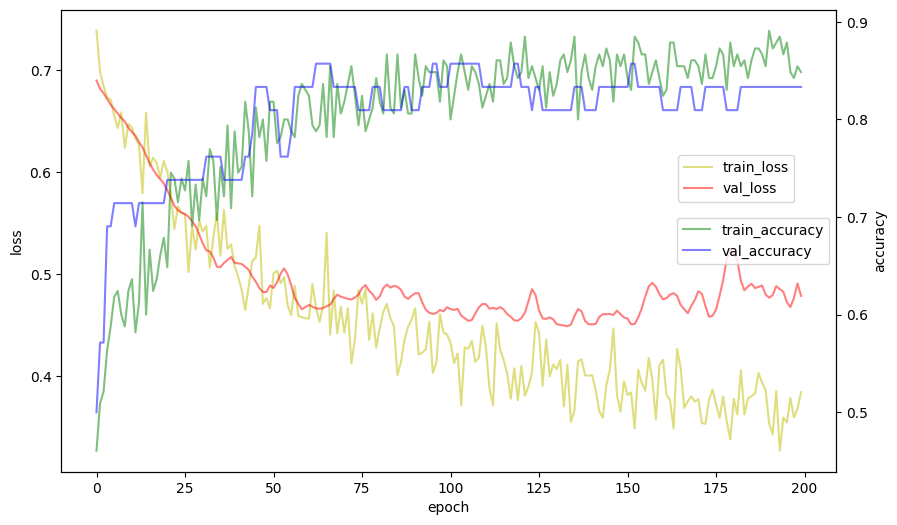

In [22]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss', alpha=0.5)
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss', alpha=0.5)
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy', alpha=0.5)
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy', alpha=0.5)
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
#loss_ax.legend(loc='lower right')
#acc_ax.legend(loc='upper right')
plt.show()

In [23]:
# 모델 평가
score = model.evaluate(x_test, y_test, verbose=0)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model precision : ', score[2])
print('model recall : ', score[3])

model loss :  0.5032917261123657
model accuracy :  0.7865168452262878
model precision :  0.761904776096344
model recall :  0.7804877758026123


In [43]:
# 교차표(혼동행렬)
x_test.reshape(-1) # 실제값

array([0.58333333, 1.        , 1.        , ..., 0.5       , 0.        ,
       0.        ])

In [40]:
y_hat = (model.predict(x_test)>0.5).astype(int).reshape(-1)
y_hat # 예측값

3/3 [==============================] - 0s 1ms/step


array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [41]:
pd.crosstab(y_test.reshape(-1), y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0,38,10
1,9,32


In [42]:
# 모델 사용
confusion_matrix(y_test, y_hat)

array([[38, 10],
       [ 9, 32]], dtype=int64)

## 4. 모델 사용
 - 저장/예측

In [44]:
X[0]

array([ 63. ,   1. ,   1. , 145. , 233. ,   1. ,   2. , 150. ,   0. ,
         2.3,   3. ,   0. ,   6. ])

In [45]:
model.save('model/07.h5')
data = [[63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3, 0, 6]]
input_data  = scaler.transform(data)
(model.predict([input_data]) > 0.5).astype(int)

1/1 [==============================] - 0s 41ms/step


array([[0]])

# 분류분석
 - x_train, y_train, x_test, y_test를 사용 -> y_train과 y_test 원핫인코딩

# 1. 데이터셋 생성 & 전처리
 - x_train, y_train, x_test, y_test를 사용 -> y_train과 y_test 원핫인코딩